In [1]:
import torch
import os

print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA available: True
Device name: Quadro RTX 4000


In [2]:
#imports
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
#loading the dataset
dataset = load_dataset("cnamuangtoun/resume-job-description-fit")

In [4]:
train = dataset['train']
test = dataset['test']

In [5]:
train_data = pd.DataFrame(train)
test_data = pd.DataFrame(test)

In [6]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [9]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 19.8 MB/s eta 0:00:0000:0100:01


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:33:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:33:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:33:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:33:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iterati

🔍 Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
🔝 Best Weighted F1 Score (CV): 0.6673327864047954

📊 Final Test Set Evaluation
Precision: 0.5435
Recall:    0.5310
F1 Score:  0.4758


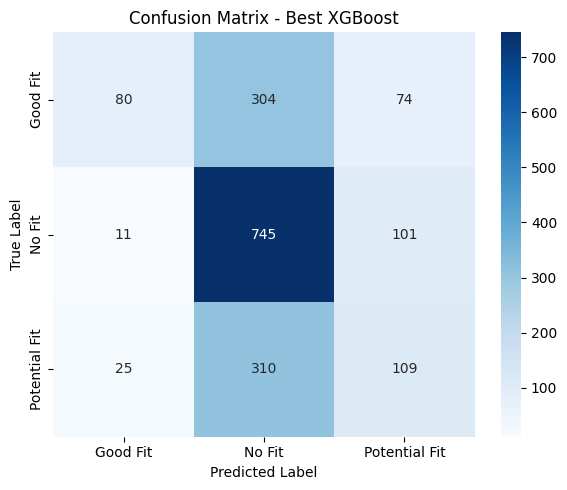

In [10]:
# 1. Imports
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier  # ✅ XGBoost import

# 2. Load dataset
dataset = load_dataset("cnamuangtoun/resume-job-description-fit")
train_data = pd.DataFrame(dataset["train"])
test_data = pd.DataFrame(dataset["test"])

# 3. Preprocessing
def preprocess_text(text):
    return text.strip()  # Case preserved for S-BERT

for col in ['resume_text', 'job_description_text']:
    train_data[col] = train_data[col].apply(preprocess_text)
    test_data[col] = test_data[col].apply(preprocess_text)

# 4. Sentence-BERT Embedding
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def compute_dual_embeddings(resumes, job_descriptions):
    resume_embeds = embedder.encode(resumes, convert_to_tensor=False, batch_size=64, show_progress_bar=True)
    jd_embeds = embedder.encode(job_descriptions, convert_to_tensor=False, batch_size=64, show_progress_bar=True)
    return np.hstack((resume_embeds, jd_embeds))

# 5. Prepare data
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

X_train = compute_dual_embeddings(train_data['resume_text'], train_data['job_description_text'])
X_test = compute_dual_embeddings(test_data['resume_text'], test_data['job_description_text'])

# 6. Grid Search for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}

grid = GridSearchCV(
    estimator=XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y_train)),
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("🔍 Best Params:", grid.best_params_)
print("🔝 Best Weighted F1 Score (CV):", grid.best_score_)

# 7. Evaluate Best Model
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 Final Test Set Evaluation")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# 8. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Best XGBoost")
plt.tight_layout()
plt.show()

## Using a different Embeddings model (SentenceTransformer('all-mpnet-base-v2')
)

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time= 1.2min
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=200; total time= 2.2min
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time= 3.5min
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=200; total time= 1.1min
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time= 1.4min
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time= 1.3min
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time= 2.4min
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=200; total time= 1.1min
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time= 1.3min
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time= 1.3min
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=200; total time= 2.5min
[CV] END ...learning_rate=0.

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=200; total time= 2.4min
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time= 2.8min
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=200; total time= 2.5min
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time= 2.7min


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:53:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:53:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:53:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:53:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iterati

🔍 Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
🔝 Best Weighted F1 Score (CV): 0.6267665359267509

📊 Final Test Set Evaluation
Precision: 0.5186
Recall:    0.5264
F1 Score:  0.4525


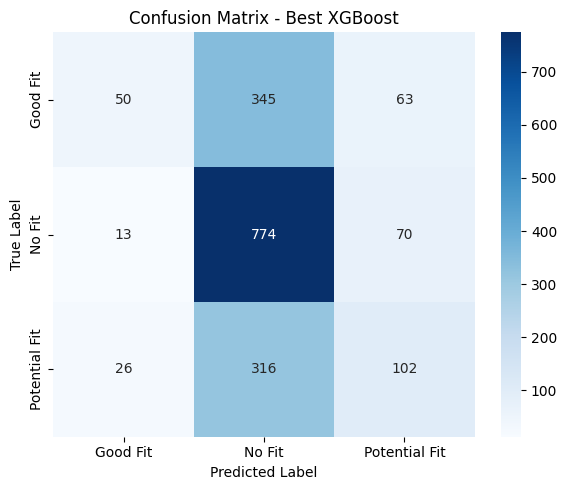

In [12]:
# 1. Imports
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier  # ✅ XGBoost import


# 3. Preprocessing
def preprocess_text(text):
    return text.strip()  # Case preserved for S-BERT

for col in ['resume_text', 'job_description_text']:
    train_data[col] = train_data[col].apply(preprocess_text)
    test_data[col] = test_data[col].apply(preprocess_text)

# 4. Sentence-BERT Embedding
embedder = SentenceTransformer('all-mpnet-base-v2')

def compute_dual_embeddings(resumes, job_descriptions):
    resume_embeds = embedder.encode(resumes, convert_to_tensor=False, batch_size=64, show_progress_bar=True)
    jd_embeds = embedder.encode(job_descriptions, convert_to_tensor=False, batch_size=64, show_progress_bar=True)
    return np.hstack((resume_embeds, jd_embeds))

# 5. Prepare data
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

X_train = compute_dual_embeddings(train_data['resume_text'], train_data['job_description_text'])
X_test = compute_dual_embeddings(test_data['resume_text'], test_data['job_description_text'])

# 6. Grid Search for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}

grid = GridSearchCV(
    estimator=XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y_train)),
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("🔍 Best Params:", grid.best_params_)
print("🔝 Best Weighted F1 Score (CV):", grid.best_score_)

# 7. Evaluate Best Model
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 Final Test Set Evaluation")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# 8. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Best XGBoost")
plt.tight_layout()
plt.show()

In [14]:
# 10. Predict on Custom Resume + Job Description
def predict_fit(resume_text, job_description_text):
    resume_text = preprocess_text(resume_text)
    job_description_text = preprocess_text(job_description_text)
    embedding = compute_dual_embeddings([resume_text], [job_description_text])
    prediction = best_xgb.predict(embedding)
    return label_encoder.inverse_transform(prediction)[0]

# Example usage
custom_resume = """Experienced software engineer with expertise in Python, Django, and REST API development. Worked on building scalable backend systems for e-commerce applications."""
custom_jd = """Looking for a backend developer skilled in Python and RESTful API design, preferably with Django experience."""

predicted_label = predict_fit(custom_resume, custom_jd)
print(f"Predicted Fit Category: {predicted_label}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted Fit Category: Potential Fit


In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_scores(resume_embed, jd_embed):
    similarities = cosine_similarity(resume_embed, jd_embed)
    return np.diag(similarities)  # each resume vs its own JD

resume_embeds = X_test[:, :384]
jd_embeds = X_test[:, 384:]


similarity_scores = compute_similarity_scores(resume_embeds, jd_embeds)


threshold = 0.6  # Adjust based on your performance tuning

ml_predictions = best_xgb.predict(X_test)
ml_labels = label_encoder.inverse_transform(ml_predictions)

intersection_indices = [
    i for i, (label, score) in enumerate(zip(ml_labels, similarity_scores))
    if label == 'Good Fit' and score >= threshold
]

# Optional: View or extract filtered results
filtered_results = test_data.iloc[intersection_indices]

# View intersected resume rows from the test set
intersected_resumes = test_data.iloc[intersection_indices][['resume_text', 'job_description_text']]
intersected_resumes.reset_index(drop=True, inplace=True)
print(intersected_resumes.head())

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 384 while Y.shape[1] == 1152

In [16]:
# Prepare color: green for intersection, gray otherwise
colors = ['green' if i in intersection_indices else 'gray' for i in range(len(similarity_scores))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(similarity_scores)), similarity_scores, c=colors, alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Resume Index')
plt.ylabel('Semantic Similarity Score')
plt.title('Resume Similarity Scores and Intersection with ML Predictions')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'similarity_scores' is not defined

[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=200; total time=   2.0s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   1.6s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=200; total time=   2.0s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=200; total time=   2.3s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time=   2.0s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   1.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   2.3s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=200; total time=   2.0s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   2.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   2.0s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=   2.2s
[CV] END ..learning_rate=0.0